<a href="https://colab.research.google.com/github/sean-halpin/chess_website/blob/models_init/models/Chess_Eval_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Download

In [1]:
# https://database.lichess.org/standard/lichess_db_standard_rated_2013-01.pgn.zst

In [2]:
!pip install zstandard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 30.6 MB/s eta 0:00:00


In [3]:
import requests
import zstandard
import io

lichess = "https://database.lichess.org/standard/"
dbfile = "lichess_db_standard_rated_2017-01.pgn.zst"
url = lichess + dbfile
compressed_file_path = dbfile
output_path = dbfile.replace(".zst","")

# Download the Zstandard compressed file
response = requests.get(url)
if response.status_code == 200:
    with open(compressed_file_path, 'wb') as file:
        file.write(response.content)
    print(f"File downloaded successfully to {compressed_file_path}")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

# Extract the Zstandard compressed file
with open(compressed_file_path, 'rb') as compressed_file:
    dctx = zstandard.ZstdDecompressor()
    with dctx.stream_reader(compressed_file) as reader:
        with open(output_path, 'wb') as output:
            output.write(reader.read())

print(f"File extracted successfully to {output_path}")


File downloaded successfully to lichess_db_standard_rated_2017-01.pgn.zst
File extracted successfully to lichess_db_standard_rated_2017-01.pgn


# Data Exploration

In [4]:
!ls

lichess_db_standard_rated_2017-01.pgn  lichess_db_standard_rated_2017-01.pgn.zst  sample_data


In [5]:
!cat lichess_db_standard_rated_2017-01.pgn | grep '\[%eval' | wc -l

1235035


In [6]:
!cat lichess_db_standard_rated_2017-01.pgn | grep '\[%eval' | head -n5

1. e4 { [%eval 0.14] } 1... e5 { [%eval 0.16] } 2. Nf3 { [%eval 0.24] } 2... Nc6 { [%eval 0.31] } 3. Bc4 { [%eval 0.15] } 3... Nd4?! { [%eval 0.94] } 4. c3 { [%eval 0.57] } 4... Nxf3+ { [%eval 0.53] } 5. Qxf3 { [%eval 0.52] } 5... Qf6 { [%eval 0.55] } 6. Qe2 { [%eval 0.5] } 6... c6 { [%eval 0.67] } 7. d3 { [%eval 0.37] } 7... Bc5 { [%eval 0.47] } 8. O-O { [%eval 0.16] } 8... Ne7 { [%eval 0.24] } 9. Kh1 { [%eval 0.16] } 9... Ng6 { [%eval 0.17] } 10. g3?! { [%eval -0.71] } 10... O-O?! { [%eval 0.09] } 11. f4?! { [%eval -0.75] } 11... exf4?! { [%eval -0.19] } 12. gxf4?! { [%eval -0.72] } 12... d5 { [%eval -0.64] } 13. exd5? { [%eval -2.46] } 13... cxd5?! { [%eval -1.54] } 14. Bxd5 { [%eval -1.62] } 14... Be6? { [%eval 0.0] } 15. Bxe6 { [%eval -0.03] } 15... fxe6 { [%eval 0.0] } 16. d4 { [%eval 0.0] } 16... Bd6 { [%eval 0.0] } 17. Be3 { [%eval -0.17] } 17... Bxf4 { [%eval -0.08] } 18. Nd2 { [%eval -0.09] } 18... Qf5 { [%eval -0.07] } 19. Nc4?? { [%eval -3.79] } 19... Qd5+ { [%eval -3.64] }

In [7]:
!cat lichess_db_standard_rated_2017-01.pgn | grep '\[%eval' > lichess.pgn.eval

In [8]:
!pip install python-chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.8 MB/s eta 0:00:00


# Data Visualisation

In [9]:
import chess.pgn
import re

pgn_text = """
1. e4 { [%eval 0.2] [%eval 0.2] } 1... e6 { [%eval 0.13] } 2. Bc4 { [%eval -0.31] } 2... d5 { [%eval -0.28] } 3. exd5 { [%eval -0.37] } 3... exd5 { [%eval -0.31] } 4. Bb3 { [%eval -0.33] } 4... Nf6 { [%eval -0.35] } 5. d4 { [%eval -0.34] } 5... Be7 { [%eval 0.0] } 6. Nf3 { [%eval 0.0] } 6... O-O { [%eval -0.08] } 7. Bg5 { [%eval -0.19] } 7... h6 { [%eval -0.29] } 8. Bxf6 { [%eval -0.36] } 8... Bxf6 { [%eval -0.37] } 9. O-O { [%eval -0.36] } 9... c6 { [%eval -0.12] } 10. Re1 { [%eval -0.17] } 10... Bf5 { [%eval -0.04] } 11. c4?! { [%eval -0.67] } 11... dxc4 { [%eval -0.5] } 12. Bxc4 { [%eval -0.77] } 12... Nd7?! { [%eval -0.1] } 13. Nc3 { [%eval 0.0] } 13... Nb6 { [%eval 0.0] } 14. b3?! { [%eval -0.76] } 14... Nxc4 { [%eval -0.49] } 15. bxc4 { [%eval -0.65] } 15... Qa5 { [%eval -0.55] } 16. Rc1 { [%eval -0.79] } 16... Rad8 { [%eval -0.78] } 17. d5?? { [%eval -5.41] } 17... Bxc3 { [%eval -5.42] } 18. Re5? { [%eval -7.61] } 18... Bxe5 { [%eval -7.78] } 19. Nxe5 { [%eval -7.72] } 19... cxd5 { [%eval -7.81] } 20. Qe1? { [%eval -9.29] } 20... Be6?? { [%eval 3.71] } 21. Rd1?? { [%eval -12.34] } 21... dxc4 { [%eval -12.71] } 22. Rxd8?! { [%eval #-1] } 22... Rxd8?! { [%eval -13.06] } 23. Qc3?! { [%eval #-2] } 23... Qxc3?! { [%eval #-4] } 24. g3 { [%eval #-3] } 24... Rd1+?! { [%eval #-4] } 25. Kg2 { [%eval #-4] } 25... Qe1?! { [%eval #-4] } 26. Kf3 { [%eval #-3] } 26... Qxe5 { [%eval #-2] } 27. Kg2 { [%eval #-2] } 27... Bd5+?! { [%eval #-2] } 28. Kh3 { [%eval #-1] } 28... Qh5# 0-1
"""

game = chess.pgn.read_game(io.StringIO(pgn_text))

board = game.board()
for node in list(game.mainline()):
    print()
    print(node.move)
    # print(node)
    print(node.comment)
    pattern = r"\[%eval\s+([#])*([\d.-]+)\]"
    match = re.search(pattern, node.comment)
    if match:
        print((match.group(1) if match.group(1) is not None else ""), match.group(2))
    else:
        print("No '%eval' found in the text.")
    board.push(node.move)
    print(board)
    checkMate = board.is_checkmate()
    print("Checkmate?", checkMate)
    i=0
    for square in chess.SQUARES:
      piece = board.piece_at(square)
      print(f"Square {chess.square_name(square)}: {piece}: {(board.piece_at(square).piece_type * (1 if board.piece_at(square).color else -1)) if piece is not None else 0}")



e2e4
[%eval 0.2] [%eval 0.2]
 0.2
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B Q K B N R
Checkmate? False
Square a1: R: 4
Square b1: N: 2
Square c1: B: 3
Square d1: Q: 5
Square e1: K: 6
Square f1: B: 3
Square g1: N: 2
Square h1: R: 4
Square a2: P: 1
Square b2: P: 1
Square c2: P: 1
Square d2: P: 1
Square e2: None: 0
Square f2: P: 1
Square g2: P: 1
Square h2: P: 1
Square a3: None: 0
Square b3: None: 0
Square c3: None: 0
Square d3: None: 0
Square e3: None: 0
Square f3: None: 0
Square g3: None: 0
Square h3: None: 0
Square a4: None: 0
Square b4: None: 0
Square c4: None: 0
Square d4: None: 0
Square e4: P: 1
Square f4: None: 0
Square g4: None: 0
Square h4: None: 0
Square a5: None: 0
Square b5: None: 0
Square c5: None: 0
Square d5: None: 0
Square e5: None: 0
Square f5: None: 0
Square g5: None: 0
Square h5: None: 0
Square a6: None: 0
Square b6: None: 0
Square c6: None: 0
Square d6: None: 0
Square e6: None: 0
Square f6: No

In [10]:
abs(float('-2.0'))

2.0

In [11]:
bound = 30

In [12]:
def bound_value(value):
    return min(max(value, -bound), bound)

# Data Preparation

In [13]:
import pandas as pd
rows_data = []
columns = []
for square in chess.SQUARES:
  piece = board.piece_at(square)
  columns.append(chess.square_name(square))
columns.append("eval")

i=0
with open('lichess.pgn.eval', 'r') as file:
    for pgn_text in file:
      # print(pgn_text)
      game = chess.pgn.read_game(io.StringIO(pgn_text))
      board = game.board()
      for node in list(game.mainline()):
          row_data = [(((board.piece_at(square).piece_type * (1 if board.piece_at(square).color else -1))) if board.piece_at(square) is not None else 0) for square in chess.SQUARES]
          pattern = r"\[%eval\s+([#])*([\d.-]+)\]"
          match = re.search(pattern, node.comment)
          if match:
            if match.group(1) is None:
              eval = bound_value(float(f"{match.group(2)}"))
              check_in = 0
            else:
              eval = 0
              if float(match.group(2)) > 0 and float(match.group(2)) <= bound:
                check_in = (bound * 2) - (float(match.group(2))*2)
              elif float(match.group(2)) < 0 and float(match.group(2)) >= -bound:
                check_in = (-bound * 2) - (float(match.group(2))*2)
              else:
                check_in = 0
              eval = check_in

          whitePlays = board.turn
          board.push(node.move)
          if board.is_checkmate():
            eval += ((bound * 4) * (-1 if whitePlays else 1))
          row_data.append(eval)
          rows_data.append(row_data)
          # move next
      i+=1
      if i % 1_000 == 0:
        print(i)
      if i >= 15_000:
        break

df = pd.DataFrame(rows_data, columns=columns)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000


In [14]:
df

,a1,b1,c1,d1,e1,f1,g1,h1,a2,b2,...,h7,a8,b8,c8,d8,e8,f8,g8,h8,eval
0,4,2,3,5,6,3,2,4,1,1,...,-1,-4,-2,-3,-5,-6,-3,-2,-4,0.14
1,4,2,3,5,6,3,2,4,1,1,...,-1,-4,-2,-3,-5,-6,-3,-2,-4,0.16
2,4,2,3,5,6,3,2,4,1,1,...,-1,-4,-2,-3,-5,-6,-3,-2,-4,0.24
3,4,2,3,5,6,3,0,4,1,1,...,-1,-4,-2,-3,-5,-6,-3,-2,-4,0.31
4,4,2,3,5,6,3,0,4,1,1,...,-1,-4,0,-3,-5,-6,-3,-2,-4,0.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
948590,0,0,4,0,0,0,0,0,1,0,...,0,0,0,-4,-4,0,0,0,0,-1.42
948591,0,0,-4,0,0,0,0,0,1,0,...,0,0,0,0,-4,0,0,0,0,-2.89
948592,0,0,-4,0,0,0,0,0,1,0,...,0,0,0,0,-4,0,0,0,0,-2.89
948593,0,0,-4,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,-11.86


In [15]:
value_ranges = df.describe().loc[['min', 'max']]
print("Value Ranges:")
print(value_ranges)

Value Ranges:
      a1   b1   c1   d1   e1   f1   g1   h1   a2   b2  ...   h7   a8   b8  \
min -6.0 -6.0 -6.0 -6.0 -6.0 -6.0 -6.0 -6.0 -6.0 -6.0  ... -6.0 -6.0 -6.0   
max  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  ...  6.0  6.0  6.0   

      c8   d8   e8   f8   g8   h8  eval  
min -6.0 -6.0 -6.0 -6.0 -6.0 -6.0 -62.0  
max  6.0  6.0  6.0  6.0  6.0  6.0  72.0  

[2 rows x 65 columns]


In [16]:
df.dtypes

a1        int64
b1        int64
c1        int64
d1        int64
e1        int64
         ...   
e8        int64
f8        int64
g8        int64
h8        int64
eval    float64
Length: 65, dtype: object

# Define Model

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

class Net(nn.Module):
    def __init__(self, input_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc2z = nn.Linear(512, 512)
        self.fc2a = nn.Linear(512, 256)
        self.fc2b = nn.Linear(256, 128)
        self.fc3_eval = nn.Linear(128, 1)  # Output for 'eval'

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc2z(x))
        x = torch.relu(self.fc2a(x))
        x = torch.relu(self.fc2b(x))
        eval_output = self.fc3_eval(x)
        return eval_output


In [18]:
import gc
gc.collect()
torch.cuda.empty_cache()

# Prepare Train & Test Data

In [19]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sampled_df = df.sample(n=750_000)

# Prepare the data
X = sampled_df.drop(columns=['eval']).values
y = sampled_df[['eval']].values

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors and move to GPU if available
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Define the model and move it to GPU if available
input_dim = X_train.shape[1]
model = Net(input_dim).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Train Model

In [20]:
# Train the model
epochs = 200
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    eval_output = model(X_train_tensor)

    # Compute the loss for 'eval' output
    eval_loss = criterion(eval_output, y_train_tensor[:, 0].view(-1, 1))  # Assuming 'eval' is the first column
    loss = eval_loss

    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

# Evaluate the model
model.eval()
with torch.no_grad():
    eval_output = model(X_test_tensor)

    # Compute the loss for 'eval' output
    eval_loss = criterion(eval_output, y_test_tensor[:, 0].view(-1, 1))  # Assuming 'eval' is the first column
    test_loss = eval_loss

    print(f'Test Loss: {test_loss.item()}')

Epoch 1/200, Loss: 229.89227294921875
Epoch 11/200, Loss: 218.08541870117188
Epoch 21/200, Loss: 174.1132049560547
Epoch 31/200, Loss: 150.84768676757812
Epoch 41/200, Loss: 133.20567321777344
Epoch 51/200, Loss: 129.94732666015625
Epoch 61/200, Loss: 127.13170623779297
Epoch 71/200, Loss: 124.76312255859375
Epoch 81/200, Loss: 123.03941345214844
Epoch 91/200, Loss: 121.59578704833984
Epoch 101/200, Loss: 120.38700103759766
Epoch 111/200, Loss: 120.31455993652344
Epoch 121/200, Loss: 118.44291687011719
Epoch 131/200, Loss: 117.57160949707031
Epoch 141/200, Loss: 117.3753890991211
Epoch 151/200, Loss: 116.34041595458984
Epoch 161/200, Loss: 115.59616088867188
Epoch 171/200, Loss: 114.95317077636719
Epoch 181/200, Loss: 120.0583724975586
Epoch 191/200, Loss: 115.17381286621094
Test Loss: 120.44418334960938


# Play Chess with Model

In [21]:
def generate_pgn(board, moves):
    game = chess.pgn.Game()

    node = game
    for move in moves:
        node = node.add_variation(move)

    game.headers["Result"] = board.result()
    return str(game)

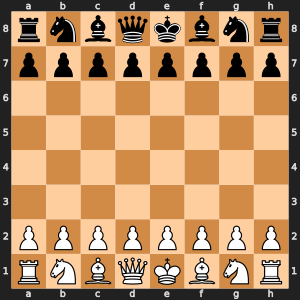

Move: 0: e2e3: 0.12666337192058563


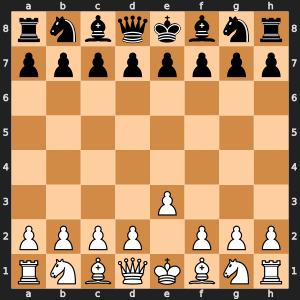

Move: 1: h7h6: 0.7762144804000854


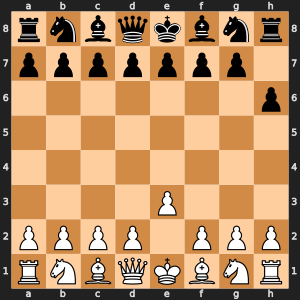

Move: 2: b1c3: 0.20704428851604462


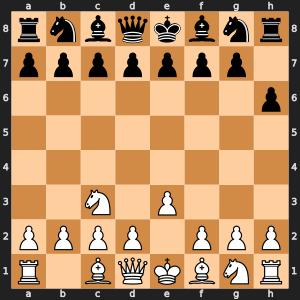

Move: 3: b8a6: 1.0259313583374023


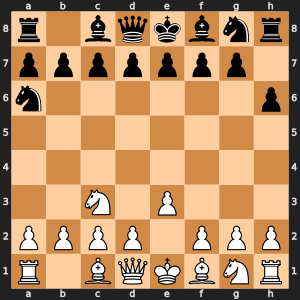

Move: 4: c3d5: 0.363921582698822


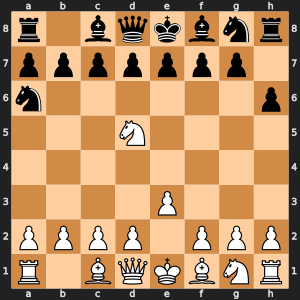

Move: 5: e7e6: 1.4937961101531982


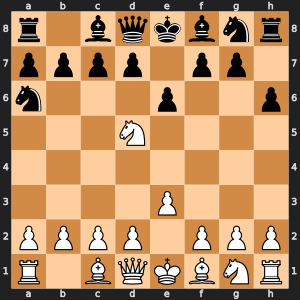

Move: 6: d5c3: 0.14642837643623352


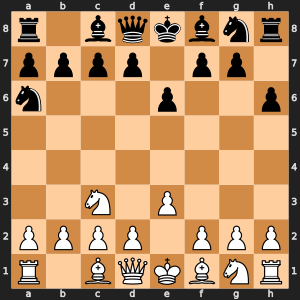

Move: 7: a6b4: -0.5805060863494873


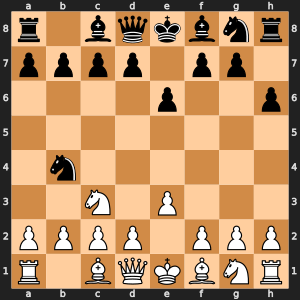

Move: 8: f1d3: -1.0040409564971924


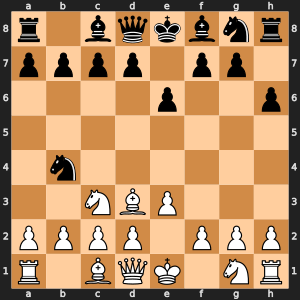

Move: 9: b4d3: -0.3730538487434387


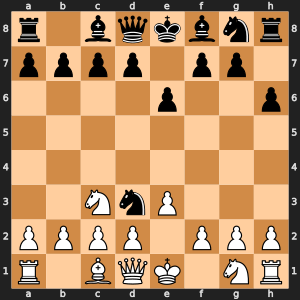

Move: 10: c2d3: -0.8035600781440735


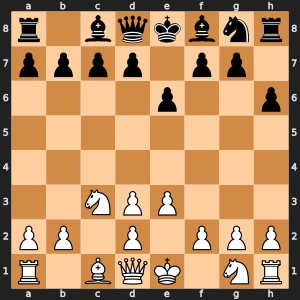

Move: 11: g8e7: -0.25409889221191406


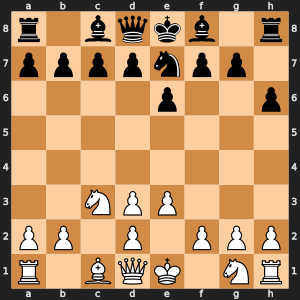

Move: 12: c3b5: 0.5902190804481506


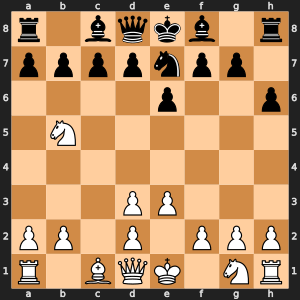

Move: 13: e7d5: 0.8750826120376587


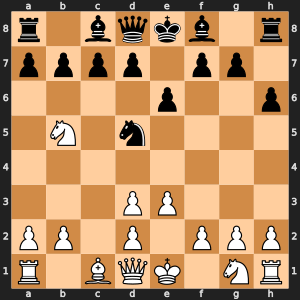

Move: 14: h2h3: -0.9773572683334351


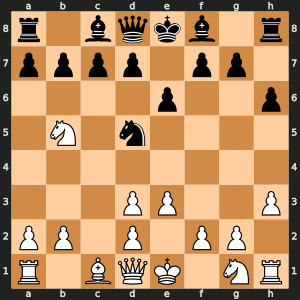

Move: 15: h8g8: -0.6358808279037476


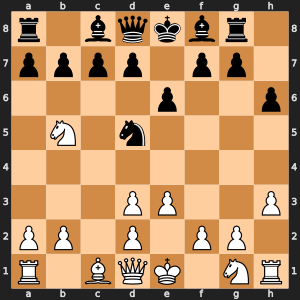

Move: 16: a2a3: -1.2367807626724243


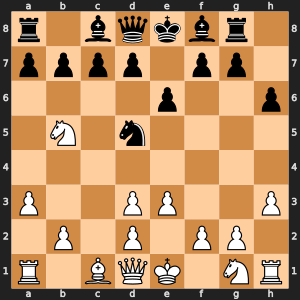

Move: 17: a7a5: -0.7445388436317444


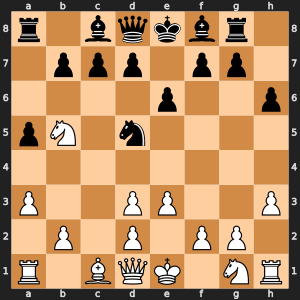

Move: 18: d3d4: -1.4018698930740356


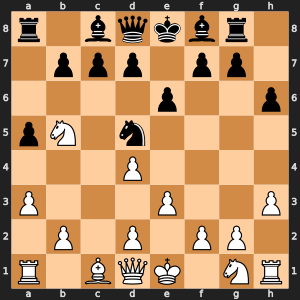

Move: 19: d7d6: -0.8052412271499634


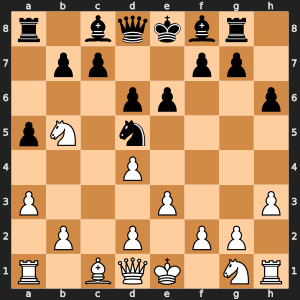

Move: 20: d2d3: -1.2928457260131836


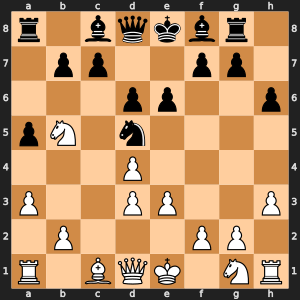

Move: 21: e6e5: -0.7678766846656799


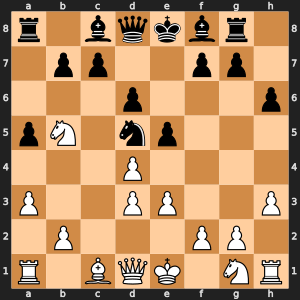

Move: 22: e3e4: -1.0170841217041016


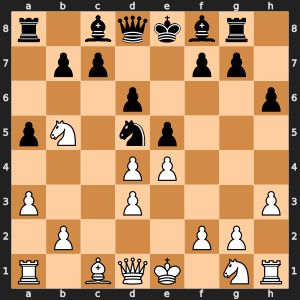

Move: 23: e5d4: -0.31138932704925537


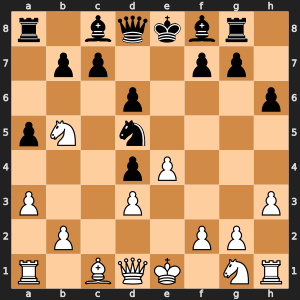

Move: 24: e4d5: -1.2154072523117065


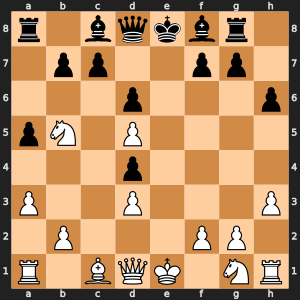

Move: 25: d8e7: -0.042129985988140106


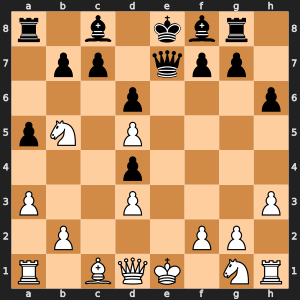

Move: 26: c1e3: 0.13016393780708313


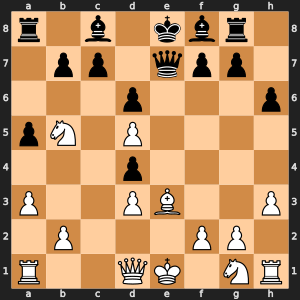

Move: 27: d4e3: 1.1606510877609253


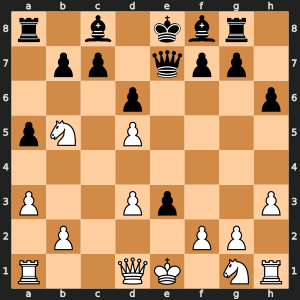

Move: 28: b5c7: -2.70827579498291


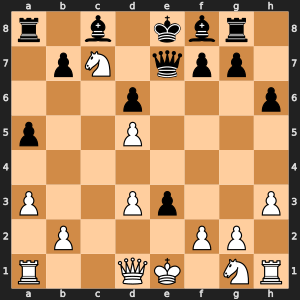

Move: 29: e7c7: 0.6098929643630981


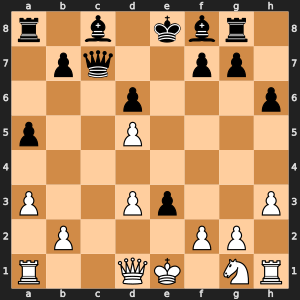

Move: 30: d3d4: -2.6181375980377197


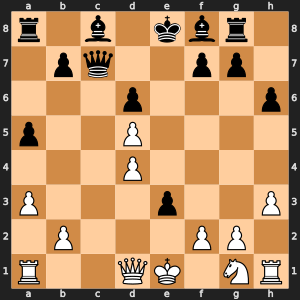

Move: 31: e3f2: -3.8053884506225586


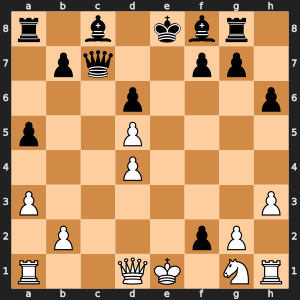

Move: 32: e1f2: -11.839789390563965


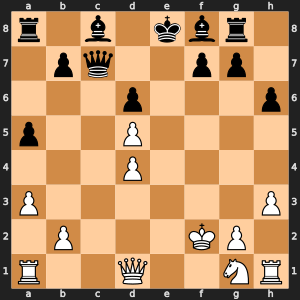

Move: 33: c7e7: -4.181320667266846


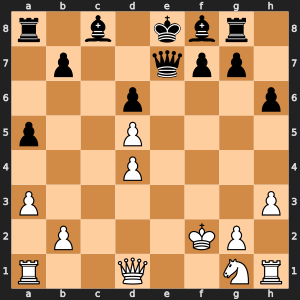

Move: 34: g1f3: -8.721834182739258


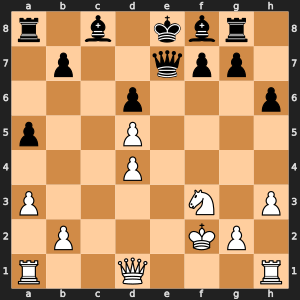

Move: 35: e7e4: -3.2737178802490234


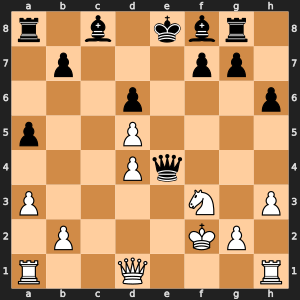

Move: 36: a1c1: -10.33523941040039


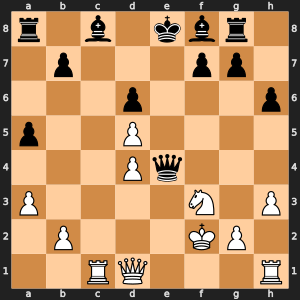

Move: 37: c8h3: -4.918710231781006


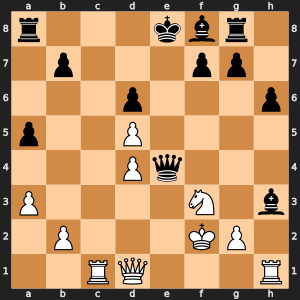

Move: 38: g2h3: -9.699750900268555


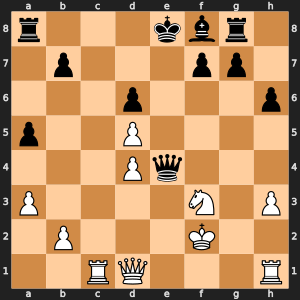

Move: 39: e4f3: -5.12868070602417


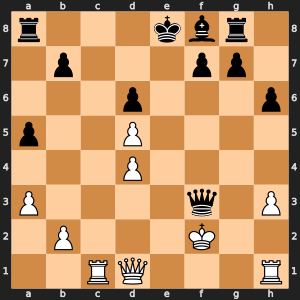

Move: 40: f2f3: -5.252177715301514


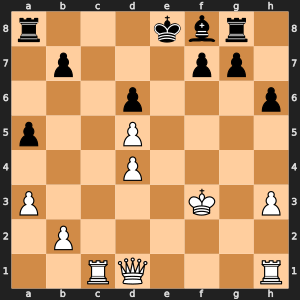

Move: 41: f8e7: -0.668818473815918


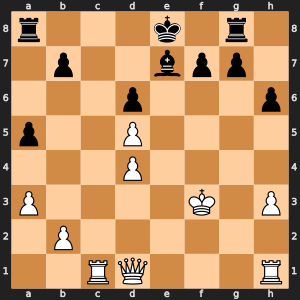

Move: 42: h1e1: -3.108337879180908


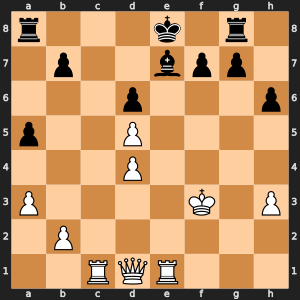

Move: 43: b7b6: 3.2295656204223633


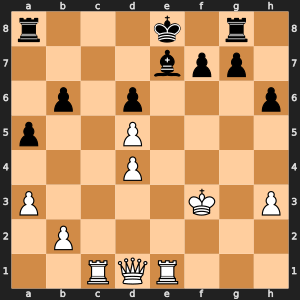

Move: 44: f3f2: 3.2295656204223633


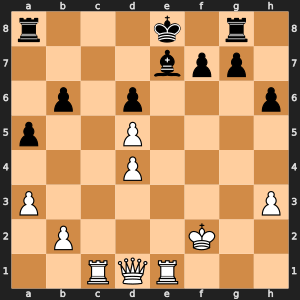

Move: 45: a8c8: 5.834179878234863


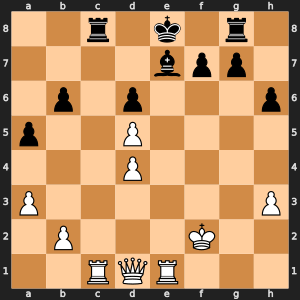

Move: 46: c1c8: 30.580310821533203


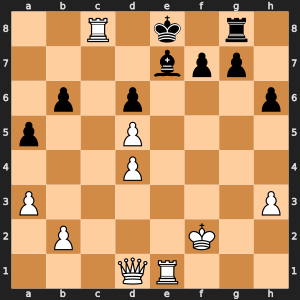

Move: 47: e8d7: 1000


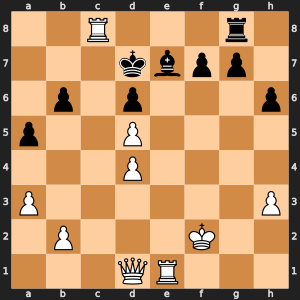

Move: 48: d1b1: 1000


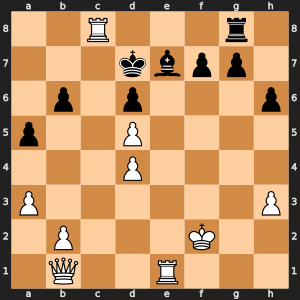

Move: 49: d7c8: 10.688243865966797


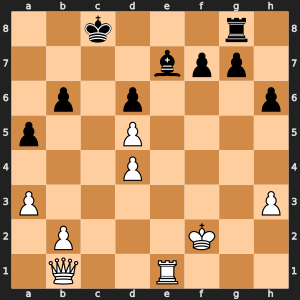

Move: 50: b1d1: 5.483827590942383


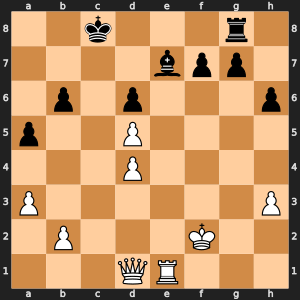

Move: 51: e7f8: 7.174630165100098


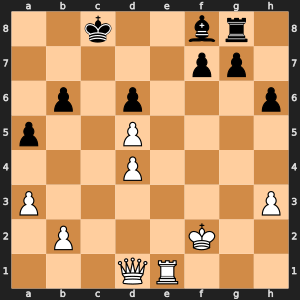

Move: 52: b2b3: 5.552984714508057


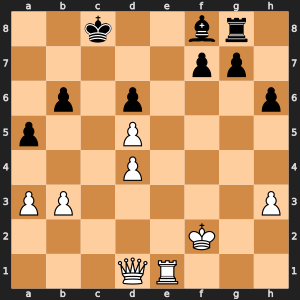

Move: 53: b6b5: 7.15341329574585


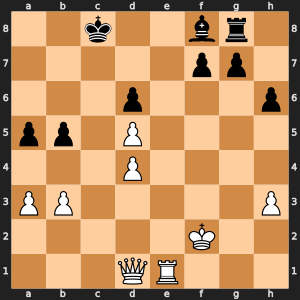

Move: 54: h3h4: 5.612244606018066


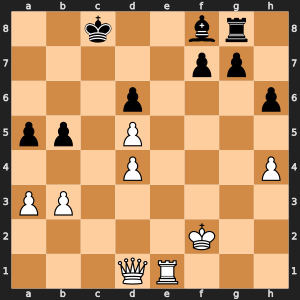

Move: 55: c8c7: 7.158475875854492


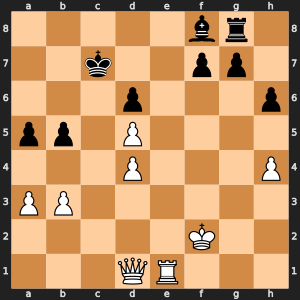

Move: 56: h4h5: 5.623713493347168


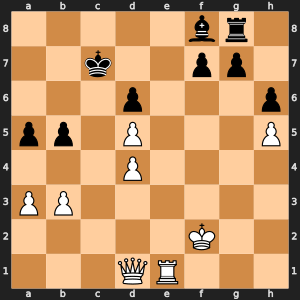

Move: 57: c7d7: 7.339638710021973


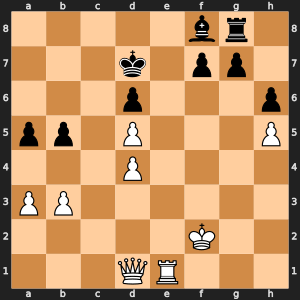

Move: 58: f2f1: 5.644567966461182


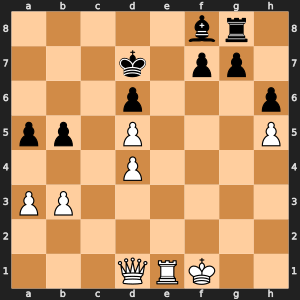

Move: 59: f7f6: 7.3625264167785645


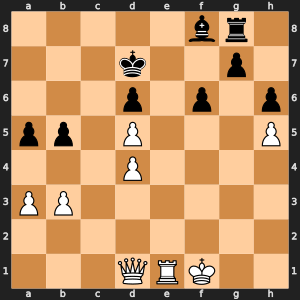

Move: 60: d1e2: 7.404477596282959


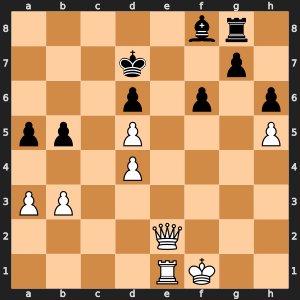

Move: 61: f8e7: 17.92668914794922


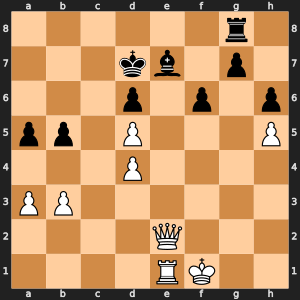

Move: 62: f1g1: 13.976275444030762


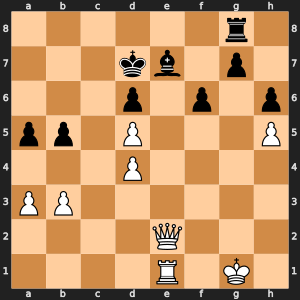

Move: 63: e7f8: 24.077852249145508


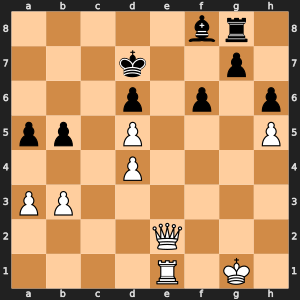

Move: 64: e2e6: 24.077852249145508


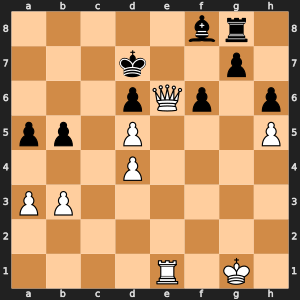

Move: 65: d7c7: 36.97321319580078


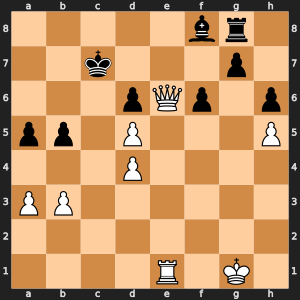

Move: 66: e6g8: 40.10114669799805


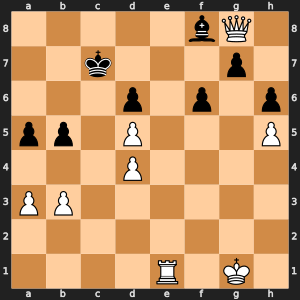

Move: 67: a5a4: 49.37729263305664


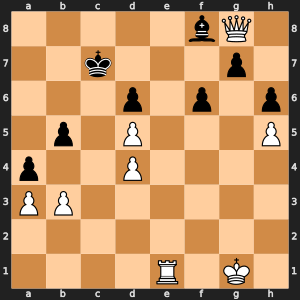

Move: 68: e1e8: 47.993404388427734


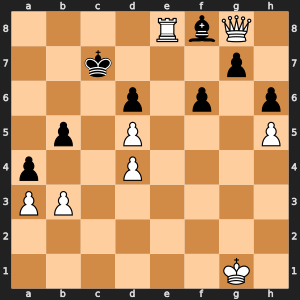

Move: 69: a4b3: 56.92167663574219


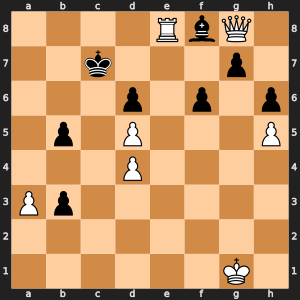

Move: 70: e8f8: 56.01197814941406


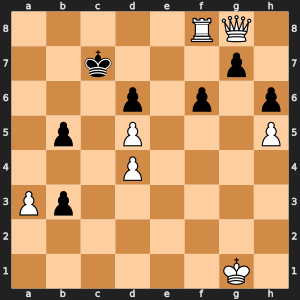

Move: 71: c7b6: 58.15692138671875


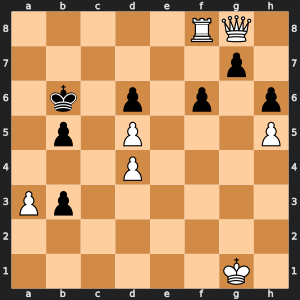

Move: 72: f8b8: 58.15692138671875


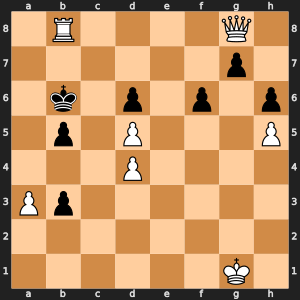

Move: 73: b6a5: 1000


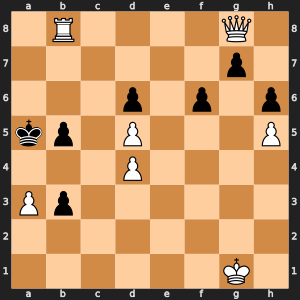

Move: 74: b8b7: 1000


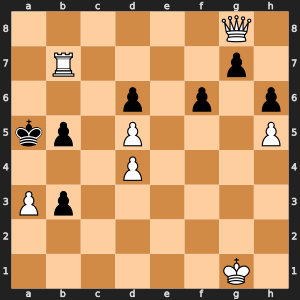

Move: 75: g7g5: 1000


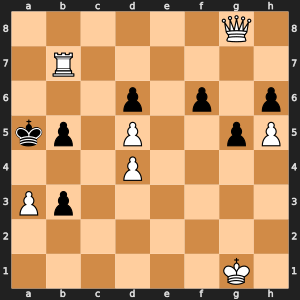

Move: 76: g8a8: 1000


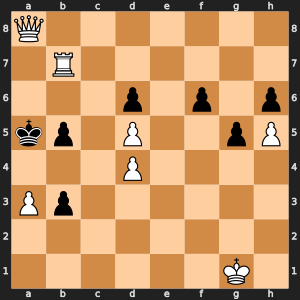

Game Over
Result:  1-0
[Event "?"]
[Site "?"]
[Date "????.??.??"]
[Round "?"]
[White "?"]
[Black "?"]
[Result "1-0"]

1. e3 h6 2. Nc3 Na6 3. Nd5 e6 4. Nc3 Nb4 5. Bd3 Nxd3+ 6. cxd3 Ne7 7. Nb5 Nd5 8. h3 Rg8 9. a3 a5 10. d4 d6 11. d3 e5 12. e4 exd4 13. exd5 Qe7+ 14. Be3 dxe3 15. Nxc7+ Qxc7 16. d4 exf2+ 17. Kxf2 Qe7 18. Nf3 Qe4 19. Rc1 Bxh3 20. gxh3 Qxf3+ 21. Kxf3 Be7 22. Re1 b6 23. Kf2 Rc8 24. Rxc8+ Kd7 25. Qb1 Kxc8 26. Qd1 Bf8 27. b3 b5 28. h4 Kc7 29. h5 Kd7 30. Kf1 f6 31. Qe2 Be7 32. Kg1 Bf8 33. Qe6+ Kc7 34. Qxg8 a4 35. Re8 axb3 36. Rxf8 Kb6 37. Rb8+ Ka5 38. Rb7 g5 39. Qa8# 1-0


In [22]:
import chess
import chess.svg
import torch
import torch.nn as nn
from IPython.display import SVG, display

# Check if GPU is available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device="cpu"

# Define a function to convert the board state into a format suitable for input to the neural network
def preprocess_board_state(board):
    board_state = [(((board.piece_at(square).piece_type * (1 if board.piece_at(square).color else -1))) if board.piece_at(square) is not None else 0) for square in chess.SQUARES]
    return torch.tensor(board_state, dtype=torch.float32).to(device)

# Define a function to generate legal moves for the current player
def generate_legal_moves(board):
    legal_moves = []
    for move in board.legal_moves:
        legal_moves.append(move)
    return legal_moves

# Minimax with alpha-beta pruning
def minimax(board, depth, alpha, beta, maximizing_player, model):
    if depth == 0 or board.is_game_over():
        if board.is_checkmate():
            if board.turn == chess.WHITE:
                return 1000, None
            else:
                return -1000, None
        return model(preprocess_board_state(board)).item(), None

    if maximizing_player:
        max_eval = float('-inf')
        best_move = None
        for move in generate_legal_moves(board):
            board.push(move)
            if board.is_checkmate():
                board.pop()
                return 1000, move  # indicating a winning position
            eval, _ = minimax(board, depth - 1, alpha, beta, False, model)
            board.pop()
            max_eval = max(max_eval, eval)
            alpha = max(alpha, eval)
            if beta <= alpha:
                break
            if eval == max_eval:
                best_move = move
        return max_eval, best_move
    else:
        min_eval = float('inf')
        best_move = None
        for move in generate_legal_moves(board):
            board.push(move)
            if board.is_checkmate():
                board.pop()
                return -1000, move  # indicating a winning position
            eval, _ = minimax(board, depth - 1, alpha, beta, True, model)
            board.pop()
            min_eval = min(min_eval, eval)
            beta = min(beta, eval)
            if beta <= alpha:
                break
            if eval == min_eval:
                best_move = move
        return min_eval, best_move


# Define the play_game function
def play_game(model, max_depth):
    board = chess.Board()
    display(SVG(chess.svg.board(board=board, size=300)))
    moves = []
    i=0
    while not board.is_game_over() and i<100:
        if board.is_checkmate() or board.is_stalemate() or board.is_insufficient_material() or board.is_seventyfive_moves():
            print("Game Over")
            print("Result: ", board.result())
            return

        legal_moves = generate_legal_moves(board)
        if len(legal_moves) == 0:
            print("Game Over - No legal moves left")
            print("Result: ", board.result())
            return

        if board.turn == chess.WHITE:
            eval, best_move = minimax(board, max_depth, float('-inf'), float('inf'), True, model)
        else:
            eval, best_move = minimax(board, max_depth, float('-inf'), float('inf'), False, model)

        board.push(best_move)
        moves.append(best_move)
        print(f"Move: {i}: {best_move}: {eval}")
        i+=1
        # print("**************************************", "\n")
        display(SVG(chess.svg.board(board=board, size=300)))

    # Print the final result of the game
    print("Game Over")
    print("Result: ", board.result())
    print(generate_pgn(board, moves))  # Generate and print the PGN


# Example usage:
# Assuming 'model' is your trained neural network model
play_game(model.to(device), max_depth=3)  # Move the model to GPU if available and set max depth to desired value
